# Portfolio financial analysis

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from scipy import stats
import seaborn as sns
import pandas_datareader as web
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

### Load similiarites and thresholds dictionnaries

In [114]:
# Load the data to analyze
with open('./data/similarities.pickle', 'rb') as simil:
    sim = pickle.load(simil)
    
# with open('./data/thresholds.pickle', 'rb') as thresholds:
#      thresh = pickle.load(thresholds)
        
with open('./data/thresholds_fixed.pickle', 'rb') as thresholds:
     thresh = pickle.load(thresholds)

In [121]:
len(thresh.keys())

59

## Compute portfolio alpha (performance)

https://www.codingfinance.com/post/2018-04-25-portfolio-beta-py/

In [164]:
def portfolio_performance(p_list, start, end, display = False):
    '''
    Function that takes as input a portfolio of companies
    Returns the alpha (performance) and beta (volatility) of the portfolio
    '''
    # Create a list of weights (uniform distribution)
    wts = [1/len(p_list)]*len(p_list)

    # Extract price data
    price_data = web.get_data_yahoo(p_list, start = start, end = end)
    price_data = price_data['Adj Close']

    # Compute daily return of the asset (percentage of increase or decrease)
    ret_data = price_data.pct_change()[1:]

    # Compute portfolio return. We multiply each column by its weight and we add all the columns together to get the portfoio return each day
    port_ret = (ret_data * wts).sum(axis = 1)

    # Get the benchmark price
    benchmark_price = web.get_data_yahoo('SPY', start = start, end = end)
    benchmark_ret = benchmark_price["Adj Close"].pct_change()[1:]
    
    # print('Extracted prices...')

    if display: # then we plot the linear regression
        sns.set(rc={'figure.figsize':(10,7)})
        sns.regplot(benchmark_ret.values, port_ret.values, scatter_kws={'s':4}, ci = None)
        plt.grid()
        plt.xlabel("Benchmark Returns")
        plt.ylabel("Portfolio Returns")
        plt.title("Portfolio Returns vs Benchmark Returns")
        plt.show()
    
    # print('Performing regression...')
    result = stats.linregress(benchmark_ret.values, port_ret.values)
    # print('Done with regression!')

    return([round(result.slope, 4), round(result.intercept, 4)])


In [156]:
class performance:
    '''
    Class that evaluates the financial performance of changers vs non-changers
    '''
    def __init__(self, similarities, thresholds, sm = 'tfidf_cosine_sim'):
        self.similarities = similarities
        self.thresholds = thresholds
        self.sm = sm
        
        
    def change_classifier(self):
        '''
        Function that takes as input a dictionnary of similarities and a threshold match
        Adds change and name column to the original similarities dictionnary
        '''
        change = {}

        for tick, simdf in self.similarities.items():
            # Load the threshold of the company
            th = self.thresholds[tick]

            # Create the change column
            simdf_change = simdf.copy(deep = True)
            simdf_change.loc[:, 'change'] = simdf_change[self.sm].apply(lambda x: True if (x <= th) else False)

            # Create the company column
            simdf_change['comp'] = tick

            # Add the df with change to the change dic
            change[tick] = simdf_change

        return(change)

    def portfolio_creation(self):
        '''
        Function that takes as input a change / no_change similarity dictionnary
        Creates, for each year, portfolios of changers and non-changers
        '''
        portfolios = {}
        
        # Get the change dic from change_classifier function
        change = self.change_classifier()

        # Concatenate the full df
        conc = change.values()
        full_change_df = pd.concat(conc, axis = 0)[['comp', 'year_2', 'change']]

        # All years
        years = full_change_df.year_2.unique()

        for year in years:
            # Filter the dataframe for this year
            df_year = full_change_df[full_change_df.year_2 == year]

            # Filter the change df and extract the changers
            df_change = df_year[df_year.change == True]
            chg = list(df_change.comp.unique())

            # Filter the no change df and extract the no changers
            df_no_change = df_year[df_year.change == False]
            no_chg = list(df_no_change.comp.unique())

            # Add the lists to the final portfolio dic
            portfolios[year] = {'change': chg, 'no_change': no_chg}

        return(portfolios)
    
    def evaluate_portfolio(self):
        '''
        Function that evaluates the previously created change / no-change portfolios for each year
        Evaluates their performance
        '''
        # Create the portfolios
        port = self.portfolio_creation()
        
        years = []
        change_perf = []
        no_change_perf = []
        
        for year, pf in port.items():
            if len(str(year)) == 1:
                clean_year = int('200{}'.format(year))
                
            else:
                clean_year = int('20{}'.format(year))
                
            print('Working on {}...'.format(clean_year))
            
            # Extract portfolios
            chg = pf['change']
            no_chg = pf['no_change']
                
            # If no company in either one or the other category
            if len(chg) == 0 or len(no_chg) == 0:
                years.append(clean_year)
                change_perf.append(None)
                no_change_perf.append(None)
                print('No company in changers or no changers!')
                print('Done with {}!'.format(clean_year))
                print('--------------------')
                continue
                
            if clean_year <= 2021:
                # Compute their alpha on the year + 1: we want to know if change between year n - 1 and year n announced bad performance on year n + 1
                start = '1-1-{}'.format(clean_year)
                end = '1-1-{}'.format(clean_year + 1)
                
            elif clean_year == 2022:
                # Compute their alpha on the first 5 months of 2022
                start = '1-1-{}'.format(clean_year)
                end = '5-1-{}'.format(clean_year)                                            
                                                  
            else:
                continue

            # Compute change score for changers and non changers
            chg_alpha = portfolio_performance(chg, start, end)[1]
            no_chg_alpha = portfolio_performance(no_chg, start, end)[1]
            
            print('Change alpha: {}'.format(chg_alpha))
            print('No change alpha: {}'.format(no_chg_alpha))
                
            # Append results to the final list
            years.append(clean_year)
            change_perf.append(chg_alpha)
            no_change_perf.append(no_chg_alpha)
            
            print('Done with {}!'.format(clean_year))
            print('--------------------')

        # Put the final results in a DataFrame (and hope for the best!)
        perf_df = pd.DataFrame({'year': years, 'change_alpha': change_perf, 'no_change_alpha': no_change_perf})
        
        return(perf_df)

In [125]:
pf = performance(sim, thresh)

In [128]:
final_eval = pf.evaluate_portfolio()

Working on 2003...
No company in changers or no changers!
Done with 2003!
--------------------
Working on 2004...
Change alpha: 0.0001
No change alpha: 0.0
Done with 2004!
--------------------
Working on 2005...
Change alpha: -0.0002
No change alpha: 0.0001
Done with 2005!
--------------------
Working on 2006...
Change alpha: -0.0008
No change alpha: 0.0002
Done with 2006!
--------------------
Working on 2007...
No company in changers or no changers!
Done with 2007!
--------------------
Working on 2008...
Change alpha: 0.0012
No change alpha: 0.0005
Done with 2008!
--------------------
Working on 2009...
Change alpha: 0.0
No change alpha: 0.0003
Done with 2009!
--------------------
Working on 2010...
Change alpha: -0.0
No change alpha: -0.0
Done with 2010!
--------------------
Working on 2011...
Change alpha: -0.0001
No change alpha: 0.0003
Done with 2011!
--------------------
Working on 2012...
Change alpha: 0.0002
No change alpha: 0.0
Done with 2012!
--------------------
Working on 2

In [134]:
def years_clean(yr):
    '''
    Clean years to put them in the good format
    '''
    if len(str(yr)) == 1:
        new_yr = '200{}'.format(yr)
        
    else:
        new_yr = '20{}'.format(yr)
        
    return(int(new_yr))

In [147]:
pfs = pf.portfolio_creation()
nb_chg_dic = {'year': pfs.keys(),
              'nb_change': [len(pf['change']) for pf in pfs.values()],
              'nb_no_change': [len(pf['no_change']) for pf in pfs.values()]}

nb_chg_df = pd.DataFrame(nb_chg_dic)

# Clean the years
nb_chg_df.year = nb_chg_df.year.apply(years_clean)

# Merge the final dfs
final_eval_clean = final_eval.merge(nb_chg_df, on = ['year'])
final_eval_clean.loc[:, 'change_diff'] = final_eval_clean.no_change_alpha - final_eval_clean.change_alpha

In [154]:
final_eval_clean.sort_values(by = 'year').reset_index(drop = True)

,year,change_alpha,no_change_alpha,nb_change,nb_no_change,change_diff
0,2002,0.0007,0.0010,1,1,0.0003
1,2003,NaN,NaN,0,11,NaN
2,2004,0.0001,0.0000,2,31,-0.0001
3,2005,-0.0002,0.0001,1,34,0.0003
4,2006,-0.0008,0.0002,1,36,0.0010
5,2007,NaN,NaN,0,41,NaN
6,2008,0.0012,0.0005,2,40,-0.0007
7,2009,0.0000,0.0003,5,38,0.0003
8,2010,-0.0000,-0.0000,40,5,0.0000
9,2011,-0.0001,0.0003,22,23,0.0004


In [150]:
final_eval_clean.change_diff.mean()

0.00022105263157894735

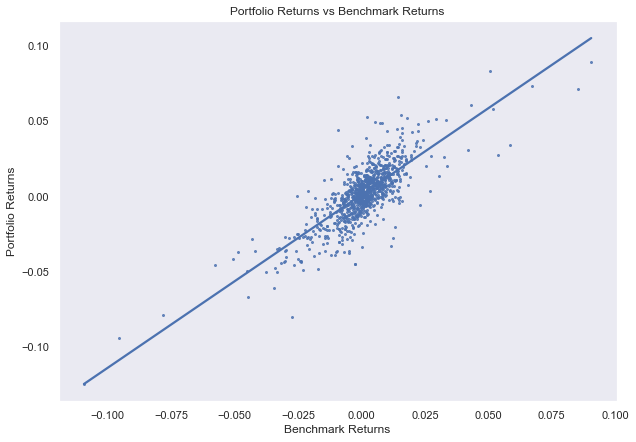

The portfolio alpha is 0.0009
The portfolio beta is 1.1469


In [165]:
beta, alpha = portfolio_performance(['AAPL', 'AMZN', 'GOOG', 'TSLA', 'FB'], start = '2018-01-01', end = '2022-01-01', display = True)

print('The portfolio alpha is {}'.format(alpha))
print('The portfolio beta is {}'.format(beta))